# Heart Disease Prediction using Apache Spark (PySpark)

**Team Members:**
- Omar Younis
- Tien Duong

**Course:** CPSC 531 - Advanced Database Systems

**Project Goal:** Build a machine learning model to predict heart disease using Apache Spark's distributed computing framework and PySpark's MLlib for scalable data processing.

**Dataset:** Kaggle Heart Disease Dataset

---


## Part 1: Setup & Installation

**Todo:**
- Install PySpark
- Import required libraries
- Create Spark session
- Verify everything works

In [ ]:
# Installing pyspark (Run this cell first - may take 1-2 minutes to finish)
!pip install pyspark
!pip install ipywidgets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.1 MB/s eta 0:00:00


In [ ]:
# PySpark SQL Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# PySpark ML imports
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# For visualization (converting to Pandas)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For timing
import time

# Status Message
print("All libraries have been successfully imported!")

All libraries have been successfully imported!


In [ ]:
# Creating a Spark Session
spark = SparkSession.builder \
                    .appName("Heart Disease Prediction") \
                    .config("spark.driver.memory", "4g") \
                    .config("spark.executor.memory", "4g") \
                    .getOrCreate()

# Checking Spark is running
print("Spark version: ", spark.version)
print("Spark session created successfully!")

# Display Spark UI URL (for monitoring purposses)
print()
print("Spark UI available at: ", spark.sparkContext.uiWebUrl)

Spark version:  4.0.1
Spark session created successfully!

Spark UI available at:  http://0d2e0188d07b:4040


# Part 2: Data Loading

**Todo:**
- Download heart disease dataset from Kaggle
- Upload CSV file to Colab
- Load data into PySpark DataFrame
- Verify the data loaded correctly

In [ ]:
# The filepath to the Kaggle Data. Make sure data is manually uploaded.
# Put the file in the content folder int he Colab project.
# Might need to upload manually between sessions.
filepath = "heart.csv"
print(f"Loading dataset from: {filepath}")

# Loading CSV into PySpark DataFrame
df = spark.read.csv(filepath, header=True, inferSchema=True)
print("Dataset loaded successfully!")

Loading dataset from: heart.csv
Dataset loaded successfully!


In [ ]:
!ls

heart.csv  sample_data


In [ ]:
# Displaying basic info
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")
print("\nColumn Headers:")
print(df.columns)

Number of rows: 1025
Number of columns: 14

Column Headers:
['Age', 'Sex', 'Chest pain type', 'Resting blood pressure', 'Serum cholestoral', 'Fasting blood sugar', 'Resting electrocardiographic results', 'Maximum heart rate achieved', 'Exercise induced angina', 'Oldpeak', 'Slope', 'Number of major vessels', 'Thal', 'target']


In [ ]:
# Show the first 5 rows
print("\nFirst 5 rows of the dataset:")
df.show(5)

# Display schema (data types of the data)
print("\nDataset schema:")
df.printSchema()


First 5 rows of the dataset:
+---+---+---------------+----------------------+-----------------+-------------------+------------------------------------+---------------------------+-----------------------+-------+-----+-----------------------+----+------+
|Age|Sex|Chest pain type|Resting blood pressure|Serum cholestoral|Fasting blood sugar|Resting electrocardiographic results|Maximum heart rate achieved|Exercise induced angina|Oldpeak|Slope|Number of major vessels|Thal|target|
+---+---+---------------+----------------------+-----------------+-------------------+------------------------------------+---------------------------+-----------------------+-------+-----+-----------------------+----+------+
| 52|  1|              0|                   125|              212|                  0|                                   1|                        168|                      0|    1.0|    2|                      2|   3|     0|
| 53|  1|              0|                   140|              203|

**Important Info about Kaggle Data:**
- age: 1 = male; 0 = female
- fbs: (fasting blood sugar > 120 mg/dl) 1 = true; 0 = false
- exang: (exercise induced angina) 1 = true; 0 = false
- thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

# Part 3: Exploratory Data Analysis (EDA)

**Todo:**
- Calculate summary statistics
- Check for missing values
- Analyze target variable distribution
- Create correlation matrix
- Visualize key patterns

In [ ]:
# Get summary statistics
print("Summary Statistics:")
df.describe().show()

Summary Statistics:
+-------+-----------------+------------------+------------------+----------------------+-----------------+-------------------+------------------------------------+---------------------------+-----------------------+------------------+------------------+-----------------------+------------------+------------------+
|summary|              Age|               Sex|   Chest pain type|Resting blood pressure|Serum cholestoral|Fasting blood sugar|Resting electrocardiographic results|Maximum heart rate achieved|Exercise induced angina|           Oldpeak|             Slope|Number of major vessels|              Thal|            target|
+-------+-----------------+------------------+------------------+----------------------+-----------------+-------------------+------------------------------------+---------------------------+-----------------------+------------------+------------------+-----------------------+------------------+------------------+
|  count|             1025|     

In [ ]:
# Check for missing values
def check_missing_values(df):
    """Checking for missing values in each column"""
    missing_counts = []

    for column in df.columns:
      null_count = df.filter(col(column).isNull()).count()
      missing_counts.append((column, null_count))

    # Create DataFrame of results
    missing_df = spark.createDataFrame(missing_counts, ["Column", "Missing Count"])
    return missing_df

missing_data = check_missing_values(df)
print("Missing Values Check:")
missing_data.show()

Missing Values Check:
+--------------------+-------------+
|              Column|Missing Count|
+--------------------+-------------+
|                 Age|            0|
|                 Sex|            0|
|     Chest pain type|            0|
|Resting blood pre...|            0|
|   Serum cholestoral|            0|
| Fasting blood sugar|            0|
|Resting electroca...|            0|
|Maximum heart rat...|            0|
|Exercise induced ...|            0|
|             Oldpeak|            0|
|               Slope|            0|
|Number of major v...|            0|
|                Thal|            0|
|              target|            0|
+--------------------+-------------+



Target Variable Distribution:
+------+-----+
|target|count|
+------+-----+
|     1|  526|
|     0|  499|
+------+-----+



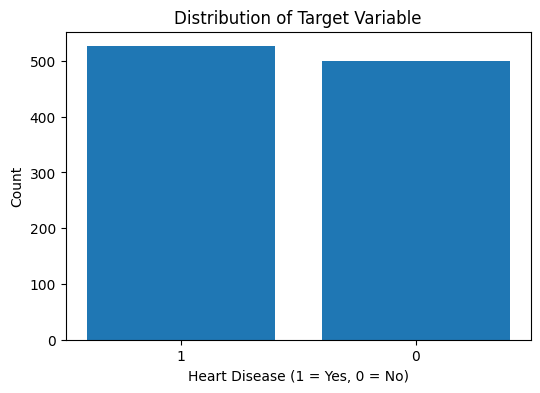

In [ ]:
# Check distribution of target variable
print("Target Variable Distribution:")
df.groupBy("target").count().show()

# Convert to Pandas dataframe for visualization
target_dist = df.groupBy("target").count().toPandas()

# Plot results
plt.figure(figsize=(6, 4))
plt.bar(target_dist['target'].astype(str), target_dist['count'])
plt.xlabel('Heart Disease (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.show()

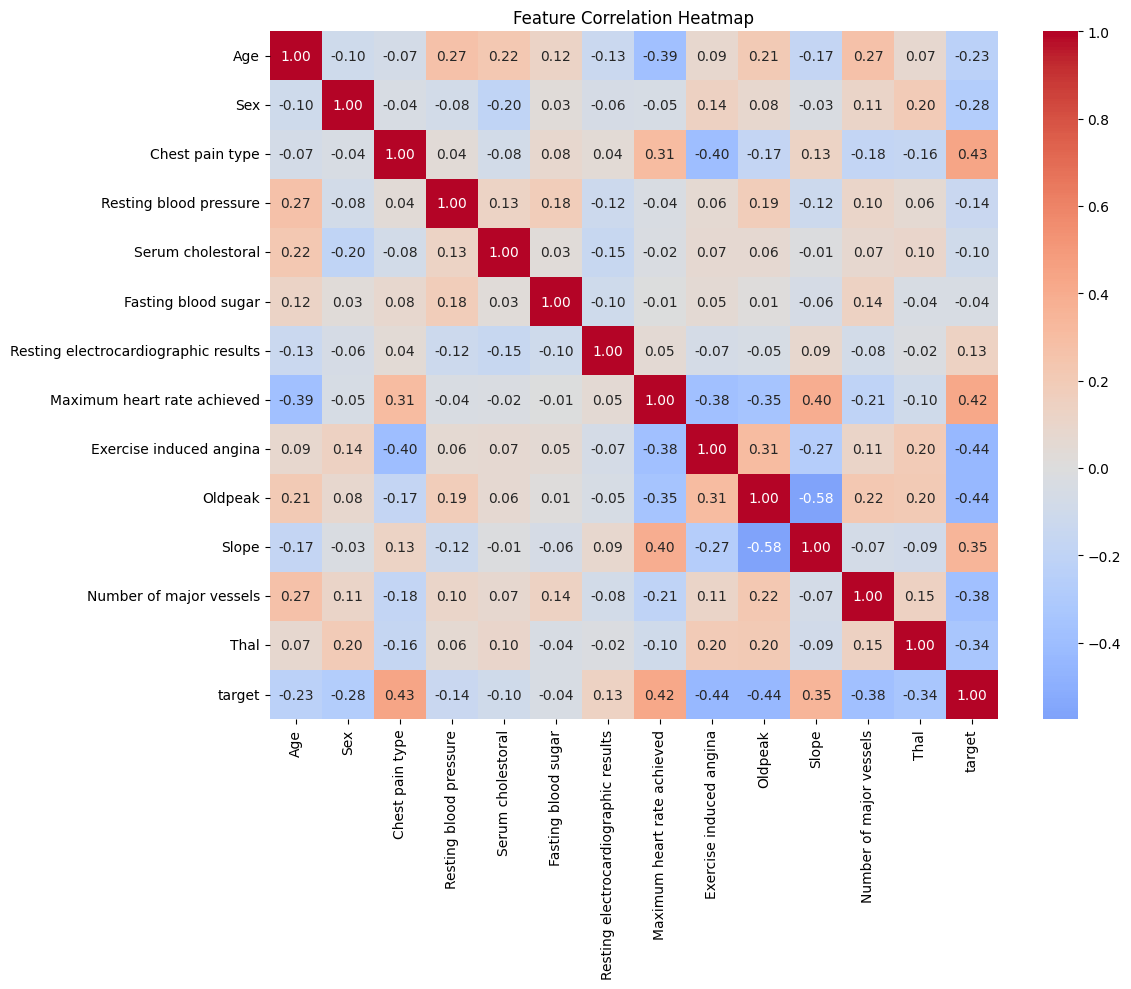


Features most correlated with target (heart disease):
target                                  1.000000
Chest pain type                         0.434854
Maximum heart rate achieved             0.422895
Slope                                   0.345512
Resting electrocardiographic results    0.134468
Fasting blood sugar                    -0.041164
Serum cholestoral                      -0.099966
Resting blood pressure                 -0.138772
Age                                    -0.229324
Sex                                    -0.279501
Thal                                   -0.337838
Number of major vessels                -0.382085
Exercise induced angina                -0.438029
Oldpeak                                -0.438441
Name: target, dtype: float64


In [ ]:
# Convert to Pandas for correlation matrix
panda_df = df.toPandas()

# Compute correlation matrix
correlation_matix = panda_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# show features most correlated with target
print("\nFeatures most correlated with target (heart disease):")
target_corr = correlation_matix['target'].sort_values(ascending=False)
print(target_corr)

In [ ]:
# Documenting key findings
print("=== KEY EDA FINDINGS ===")
print(f"1. Total samples: {df.count()}")
print(f"2. Total features: {len(df.columns) - 1}")  # Subtracting Target field
print(f"3. Missing values: {missing_data.filter(col('Missing Count') > 0).count()} columns")
print(f"4. Class balance {target_dist.to_dict()}")
print(f"5. Top 3 correlated features with target:")
print(target_corr.head(4))  # Top 3 plus Target

=== KEY EDA FINDINGS ===
1. Total samples: 1025
2. Total features: 13
3. Missing values: 0 columns
4. Class balance {'target': {0: 1, 1: 0}, 'count': {0: 526, 1: 499}}
5. Top 3 correlated features with target:
target                         1.000000
Chest pain type                0.434854
Maximum heart rate achieved    0.422895
Slope                          0.345512
Name: target, dtype: float64


# Part 4: Data Preprocessing

**Todo:**
- Select feature column
- Create feature vectors using VectorAssembler
- Scale features using StandardScaler
- Split data into 80% training, 20% testing

In [ ]:
# Define feature columns (excluding 'target')
feature_columns = [col for col in df.columns if col != 'target']

print(f"Feature columns: {feature_columns}")
print(f"Number of Feature columns: {len(feature_columns)}")
print("Target column: target")

Feature columns: ['Age', 'Sex', 'Chest pain type', 'Resting blood pressure', 'Serum cholestoral', 'Fasting blood sugar', 'Resting electrocardiographic results', 'Maximum heart rate achieved', 'Exercise induced angina', 'Oldpeak', 'Slope', 'Number of major vessels', 'Thal']
Number of Feature columns: 13
Target column: target


In [ ]:
# VectorAssembler combines multiple columns into a single vector column (required for PySpark ML)
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features_raw"
)

# Apply transformation
df_assembled = assembler.transform(df)

print("Feature. vector created")
df_assembled.select("features_raw", "target").show(5, truncate=False)

Feature. vector created
+------------------------------------------------------------+------+
|features_raw                                                |target|
+------------------------------------------------------------+------+
|[52.0,1.0,0.0,125.0,212.0,0.0,1.0,168.0,0.0,1.0,2.0,2.0,3.0]|0     |
|[53.0,1.0,0.0,140.0,203.0,1.0,0.0,155.0,1.0,3.1,0.0,0.0,3.0]|0     |
|[70.0,1.0,0.0,145.0,174.0,0.0,1.0,125.0,1.0,2.6,0.0,0.0,3.0]|0     |
|[61.0,1.0,0.0,148.0,203.0,0.0,1.0,161.0,0.0,0.0,2.0,1.0,3.0]|0     |
|[62.0,0.0,0.0,138.0,294.0,1.0,1.0,106.0,0.0,1.9,1.0,3.0,2.0]|0     |
+------------------------------------------------------------+------+
only showing top 5 rows


In [ ]:
# Normalize features to have similar scales to improve model performance
# StandardScaler standardizes features to have mean=0 and stddev=1
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)

# Fit the scaler on the data
scaler_model = scaler.fit(df_assembled)

# Transform the data
df_scaled = scaler_model.transform(df_assembled)

print("Features scaled successfully!")
df_scaled.select("features", "target").show(5, truncate=False)

Features scaled successfully!
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features                                                                                                                                                                                                                                                        |target|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|[-0.2683056073915854,0.6611813238408427,-0.9153085969123099,-0.3774512619912096,-0.6590103847268498,-0.41867354389978134,0.8908200157527675,0.8209197792283717,-0.711939577

In [ ]:
# Split data: 80% training, 20% testing
# Set seed so that this is reproducible
train_data, test_data = df_scaled.randomSplit([0.8, 0.2], seed=42)

print(f"Training samples: {train_data.count()}")
print(f"Testing samples: {test_data.count()}")
print(f"Split ratio: {train_data.count() / df_scaled.count():.2%} train, {test_data.count() / df_scaled.count():.2%} test")

Training samples: 856
Testing samples: 169
Split ratio: 83.51% train, 16.49% test


# Part 5: Model Training - Logistic Regression

**Todo:**
- Initialize Logistic Regression model
- Train the model on training data
- Make predictions on test data
- Understand the output

In [ ]:
# Create Logistic Regression model
lr = LogisticRegression(
    featuresCol="features",
    labelCol="target",
    maxIter=100,    # Max number of iterations
    regParam=0.01,  # Regularization parameter
    elasticNetParam=0.0  # L2 regularization to prevent overfitting.
)

print("Logitic Regression model initialized")
print("Model parameters:")
print(f"  - Max iterations: {lr.getMaxIter()}")
print(f"  - Regularization: {lr.getRegParam()}")

Logitic Regression model initialized
Model parameters:
  - Max iterations: 100
  - Regularization: 0.01


In [ ]:
# Start timing for training length
start_time = time.time()

# Train model
print("Training Logistic Regression model...")
lr_model = lr.fit(train_data)

# Training Time Elapsed
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

Training Logistic Regression model...
Training completed in 5.82 seconds


In [ ]:
# Make predictions on test data
lr_predictions = lr_model.transform(test_data)

# Show predictions
print("Sample predictions:")
lr_predictions.select("target", "prediction", "probability").show(10, truncate=False)

Sample predictions:
+------+----------+-----------------------------------------+
|target|prediction|probability                              |
+------+----------+-----------------------------------------+
|1     |1.0       |[0.051736117584112964,0.948263882415887] |
|1     |1.0       |[0.013724624644347965,0.986275375355652] |
|1     |1.0       |[0.01960576893378458,0.9803942310662154] |
|1     |1.0       |[0.05697979452929716,0.9430202054707029] |
|0     |0.0       |[0.7198775431488165,0.28012245685118353] |
|1     |1.0       |[0.0633359310670541,0.936664068932946]   |
|1     |1.0       |[0.35469724139335823,0.6453027586066418] |
|1     |1.0       |[0.3138920717427983,0.6861079282572017]  |
|1     |1.0       |[0.00468595388916121,0.9953140461108387] |
|1     |1.0       |[0.024262913060959335,0.9757370869390407]|
+------+----------+-----------------------------------------+
only showing top 10 rows


**NOTES:**
- `target`: Actual value (0 or 1) [false or true]
- `prediction`: Model's prediction (0 or 1)
- `probability`: Confidence score (prob or 0, prob of 1)

# Part 6: Model Evaluation

**Todo:**
- Calculate accuracy, precision, recall, F1-score
- Calculate ROC-AUC score
- Create confusion matrix
- Visualize results
- Save model performance metrics

In [ ]:
# Accuracy evaluator
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="target",
    predictionCol="prediction",
    metricName="accuracy"
)

lr_accuracy = accuracy_evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")

Logistic Regression Accuracy: 0.8284 (82.84%)


In [ ]:
# Precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="target",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

lr_precision = precision_evaluator.evaluate(lr_predictions)

# Recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="target",
    predictionCol="prediction",
    metricName="weightedRecall"
)

lr_recall = recall_evaluator.evaluate(lr_predictions)

# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="target",
    predictionCol="prediction",
    metricName="f1"
)

lr_f1 = f1_evaluator.evaluate(lr_predictions)

print("\n=== Logistic Regression Performance ===")
print(f"Accuracy:  {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"Precision: {lr_precision:.4f} ({lr_precision*100:.2f}%)")
print(f"Recall:    {lr_recall:.4f} ({lr_recall*100:.2f}%)")
print(f"F1-Score:  {lr_f1:.4f} ({lr_f1*100:.2f}%)")


=== Logistic Regression Performance ===
Accuracy:  0.8284 (82.84%)
Precision: 0.8412 (84.12%)
Recall:    0.8284 (82.84%)
F1-Score:  0.8282 (82.82%)


In [ ]:
# ROC-AUC evaluator
roc_evaluator = BinaryClassificationEvaluator(
    labelCol="target",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

lr_auc = roc_evaluator.evaluate(lr_predictions)
print(f"\nROC-AUC Score: {lr_auc:.4f} ({lr_auc*100:.2f}%)")


ROC-AUC Score: 0.9189 (91.89%)



Confusion Matrix:
prediction  0.0  1.0
target              
0            69   22
1             7   71


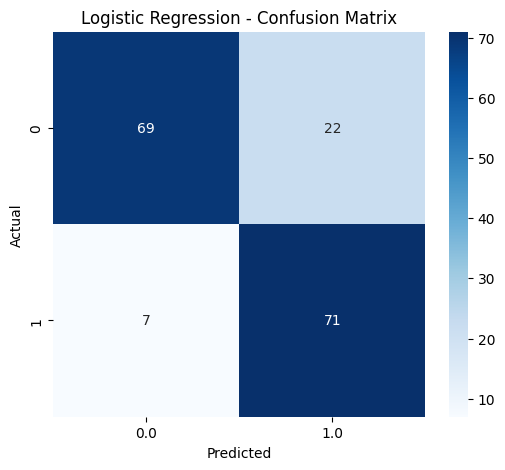


True Positive: 71
True Negative: 69
False Positive: 22
False Negative: 7


In [ ]:
from numpy._core.defchararray import index
# Create confusion matrix
confusion_matrix = lr_predictions.groupBy("target", "prediction").count()
confusion_matrix_pd = confusion_matrix.toPandas().pivot(index='target', columns='prediction', values='count').fillna(0)

print("\nConfusion Matrix:")
print(confusion_matrix_pd)

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix_pd, annot=True, fmt='.0f', cmap='Blues')
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculates specific metrics from confusion matrix
true_neg = confusion_matrix_pd.loc[0,0] if 0 in confusion_matrix_pd.index and 0 in confusion_matrix_pd.columns else 0
false_pos = confusion_matrix_pd.loc[0,1] if 0 in confusion_matrix_pd.index and 1 in confusion_matrix_pd.columns else 0
false_neg = confusion_matrix_pd.loc[1,0] if 1 in confusion_matrix_pd.index and 0 in confusion_matrix_pd.columns else 0
true_pos = confusion_matrix_pd.loc[1,1] if 1 in confusion_matrix_pd.index and 1 in confusion_matrix_pd.columns else 0

print(f"\nTrue Positive: {true_pos}")
print(f"True Negative: {true_neg}")
print(f"False Positive: {false_pos}")
print(f"False Negative: {false_neg}")

In [ ]:
# Store results in a dictionary
lr_results = {
    "Model": "Logistic Regression",
    "Accuracy": lr_accuracy,
    "Precision": lr_precision,
    "Recall": lr_recall,
    "F1-Score": lr_f1,
    "ROC-AUC": lr_auc,
    "Training Time (s)": training_time,
}

print("\nResults save for comparison:")
for key, value in lr_results.items():
  print(f"{key:>20}: \t{value}")


Results save for comparison:
               Model: 	Logistic Regression
            Accuracy: 	0.8284023668639053
           Precision: 	0.8412237168603893
              Recall: 	0.8284023668639053
            F1-Score: 	0.8282220983134945
             ROC-AUC: 	0.9188503803888415
   Training Time (s): 	5.821576833724976


# Part 7: Alternative Models

**Todo:**
- Train Random Forest Classifier
- Train Decision Tree Classifier (optional)
- Evaluate each model
- Compare with Logistic Regression

In [ ]:
# Create Random Forest model
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="target",
    numTrees=100,     # Number of trees in the forest
    maxDepth=5,       # Maximum depth of each tree
    seed=42           # Seed for reproducibility
)

print("Training Random Forest model...")
start_time = time.time()

# Train model
rf_model = rf.fit(train_data)

# Training Time Elapsed
rf_training_time = time.time() - start_time
print(f"Training completed in {rf_training_time:.2f} seconds")

# Make predictions
rf_predictions = rf_model.transform(test_data)

# Evaluate
rf_accuracy = accuracy_evaluator.evaluate(rf_predictions)
rf_precision = precision_evaluator.evaluate(rf_predictions)
rf_recall = recall_evaluator.evaluate(rf_predictions)
rf_f1 = f1_evaluator.evaluate(rf_predictions)
rf_auc = roc_evaluator.evaluate(rf_predictions)

print("\n=== Random Forest Performance ===")
print(f"Accuracy:  {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"Precision: {rf_precision:.4f} ({rf_precision*100:.2f}%)")
print(f"Recall:    {rf_recall:.4f} ({rf_recall*100:.2f}%)")
print(f"F1-Score:  {rf_f1:.4f} ({rf_f1*100:.2f}%)")
print(f"ROC-AUC:   {rf_auc:.4f} ({rf_auc*100:.2f}%)")

# Save results
rf_results = {
    "Model": "Random Forest",
    "Accuracy": rf_accuracy,
    "Precision": rf_precision,
    "Recall": rf_recall,
    "F1-Score": rf_f1,
    "ROC-AUC": rf_auc,
    "Training Time (s)": rf_training_time,
}

print("\nResults save for comparison:")
for key, value in rf_results.items():
  print(f"{key:>20}: \t{value}")

Training Random Forest model...
Training completed in 5.46 seconds

=== Random Forest Performance ===
Accuracy:  0.9231 (92.31%)
Precision: 0.9265 (92.65%)
Recall:    0.9231 (92.31%)
F1-Score:  0.9232 (92.32%)
ROC-AUC:   0.9837 (98.37%)

Results save for comparison:
               Model: 	Random Forest
            Accuracy: 	0.9230769230769231
           Precision: 	0.9264705882352942
              Recall: 	0.9230769230769231
            F1-Score: 	0.9231901840490797
             ROC-AUC: 	0.9836573682727529
   Training Time (s): 	5.457115411758423


In [ ]:
# Create Decision Tree Model
dt = DecisionTreeClassifier(
    featuresCol="features",
    labelCol="target",
    maxDepth=5,
    seed=42
)

print("Training Decision Tree model...")
start_time = time.time()

# Train model
dt_model = dt.fit(train_data)

dt_training_time = time.time() - start_time
print(f"Training completed in {dt_training_time:.2f} seconds")

# Make predictions
dt_predictions = dt_model.transform(test_data)

# Evaluate
dt_accuracy = accuracy_evaluator.evaluate(dt_predictions)
dt_precision = precision_evaluator.evaluate(dt_predictions)
dt_recall = recall_evaluator.evaluate(dt_predictions)
dt_f1 = f1_evaluator.evaluate(dt_predictions)
dt_auc = roc_evaluator.evaluate(dt_predictions)

print("\n=== Decision Tree Performance ===")
print(f"Accuracy:  {dt_accuracy:.4f} ({dt_accuracy*100:.2f}%)")
print(f"Precision: {dt_precision:.4f} ({dt_precision*100:.2f}%)")
print(f"Recall:    {dt_recall:.4f} ({dt_recall*100:.2f}%)")
print(f"F1-Score:  {dt_f1:.4f} ({dt_f1*100:.2f}%)")
print(f"ROC-AUC:   {dt_auc:.4f} ({dt_auc*100:.2f}%)")

# Save results
dt_results = {
    "Model": "Decision Tree",
    "Accuracy": dt_accuracy,
    "Precision": dt_precision,
    "Recall": dt_recall,
    "F1-Score": dt_f1,
    "ROC-AUC": dt_auc,
    "Training Time (s)": dt_training_time,
}

print("\nResults save for comparison:")
for key, value in dt_results.items():
  print(f"{key:>20}: \t{value}")


Training Decision Tree model...
Training completed in 1.62 seconds

=== Decision Tree Performance ===
Accuracy:  0.8817 (88.17%)
Precision: 0.8973 (89.73%)
Recall:    0.8817 (88.17%)
F1-Score:  0.8815 (88.15%)
ROC-AUC:   0.9360 (93.60%)

Results save for comparison:
               Model: 	Decision Tree
            Accuracy: 	0.8816568047337278
           Precision: 	0.8972613202400437
              Recall: 	0.8816568047337279
            F1-Score: 	0.8814578528784189
             ROC-AUC: 	0.9359678782755706
   Training Time (s): 	1.6204500198364258


# Part 8: Model Comparison

**Todo:**
- Create comparison table of all models
- Visualize performance metrics
- Identify best performing model
- Document findings for report

In [ ]:
# Combine all results
all_results = [lr_results, rf_results, dt_results]

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results)

print("\n" + "="*70)
print("MODEL COMPARISON TABLE")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)


MODEL COMPARISON TABLE
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Training Time (s)
Logistic Regression  0.828402   0.841224 0.828402  0.828222 0.918850           5.821577
      Random Forest  0.923077   0.926471 0.923077  0.923190 0.983657           5.457115
      Decision Tree  0.881657   0.897261 0.881657  0.881458 0.935968           1.620450


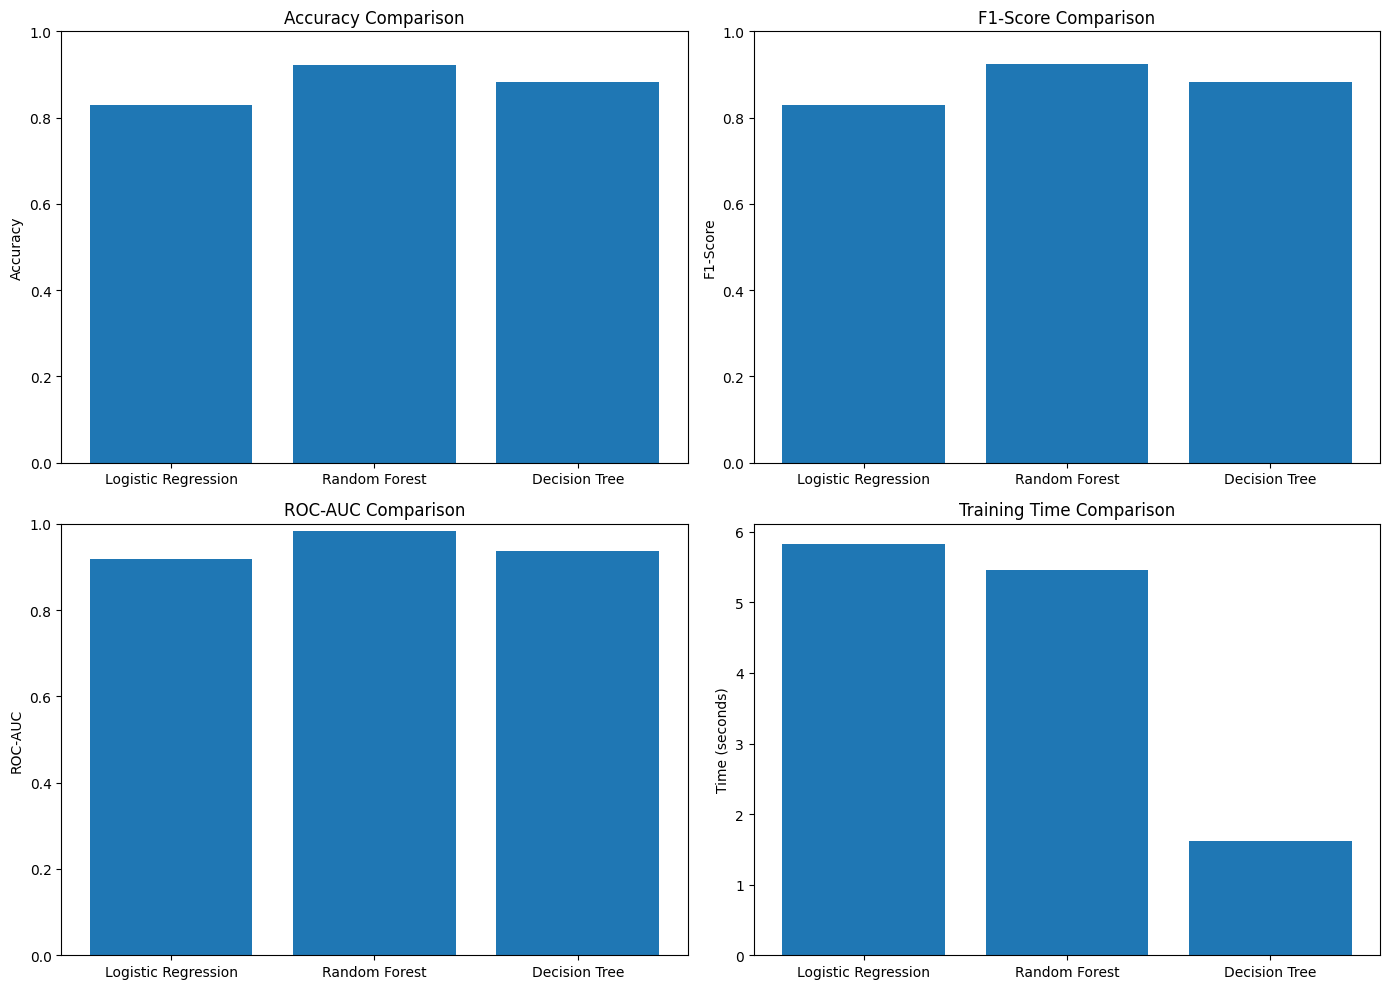

In [ ]:
# Plot accuracy comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axes[0, 0].bar(comparison_df['Model'], comparison_df['Accuracy'])
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0, 1])

# F1-Score
axes[0, 1].bar(comparison_df['Model'], comparison_df['F1-Score'])
axes[0, 1].set_title('F1-Score Comparison')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim([0, 1])

# ROC-AUC
axes[1, 0].bar(comparison_df['Model'], comparison_df['ROC-AUC'])
axes[1, 0].set_title('ROC-AUC Comparison')
axes[1, 0].set_ylabel('ROC-AUC')
axes[1, 0].set_ylim([0, 1])

# Training Time
axes[1, 1].bar(comparison_df['Model'], comparison_df['Training Time (s)'])
axes[1, 1].set_title('Training Time Comparison')
axes[1, 1].set_ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [ ]:
# Find best model by accuracy
best_model_idx = comparison_df['Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_accuracy = comparison_df.loc[best_model_idx, 'Accuracy']

print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Find best model by F1-Score
best_f1_idx = comparison_df['F1-Score'].idxmax()
best_f1_model = comparison_df.loc[best_f1_idx, 'Model']
best_f1 = comparison_df.loc[best_f1_idx, 'F1-Score']

print(f"\nBest F1-Score: {best_f1_model} with {best_f1:.4f}")


Best Model: Random Forest
Best Accuracy: 0.9231 (92.31%)

Best F1-Score: Random Forest with 0.9232


# Part 9: Simple Prediction Interface

**Todo:**
- Create a prediction function
- Test with sample patients
- Build interactive widget (optional)
- Display predictions with risk levels

In [ ]:
def predict_heart_disease(
      age,
      sex,
      cp,
      trestbps,
      chol,
      fbs,
      restecg,
      thalach,
      exang,
      oldpeak,
      slope,
      ca,
      thal,
      model=lr_model,
      scaler=scaler_model,
      assembler=assembler
    ):
    """
    Predict heart disease for a patient.

    Parameters match the dataset columns (except target):
    - age: Age in years
    - sex: Sex (1 = male, 0 = female)
    - cp: Chest pain type (0-3)
    - trestbps: Resting blood pressure
    - chol: Serum cholesterol in mg/dl
    - fbs: Fasting blood sugar > 120 mg/dl (1 = true, 0 = false)
    - restecg: Resting electrocardiographic results (0-2)
    - thalach: Maximum heart rate achieved
    - exang: Exercise induced angina (1 = yes, 0 = no)
    - oldpeak: ST depression induced by exercise
    - slope: Slope of the peak exercise ST segment (0-2)
    - ca: Number of major vessels colored by fluoroscopy (0-3)
    - thal: Thalassemia (1 = normal, 2 = fixed defect, 3 = reversible defect)

    Returns:
    - Prediction (0 = No heart disease, 1 = Heart disease)
    - Probability score
    """

    # Create DataFrame from input
    input_data = spark.createDataFrame([
        (age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal)
    ], feature_columns)

    # Apply same preprocessing
    input_assembled = assembler.transform(input_data)
    input_scaled = scaler.transform(input_assembled)

    # Make prediction
    prediction = model.transform(input_scaled)

    # Extract results
    result = prediction.select("prediction", "probability").collect()[0]
    pred_class = int(result['prediction'])
    prob = result['probability'].toArray()

    # Display results
    print("="*50)
    print("HEART DISEASE PREDICTION RESULT")
    print("="*50)
    print(f"Prediction: {'HEART DISEASE DETECTED' if pred_class == 1 else 'NO HEART DISEASE'}")
    print(f"Confidence: {prob[pred_class]*100:.2f}%")
    print(f"\nProbability of No Disease: {prob[0]*100:.2f}%")
    print(f"Probability of Disease:    {prob[1]*100:.2f}%")
    print("="*50)

    # Risk level
    risk_score = prob[1]
    if risk_score < 0.3:
        risk_level = "LOW"
        color = "🟢"
    elif risk_score < 0.7:
        risk_level = "MEDIUM"
        color = "🟡"
    else:
        risk_level = "HIGH"
        color = "🔴"

    print(f"\nRisk Level: {color} {risk_level}")
    print("="*50)

    return pred_class, prob

print("Prediction function created successfully!")

Prediction function created successfully!


In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create input widgets
age_widget = widgets.IntSlider(value=50, min=0, max=100, description='Age:')
sex_widget = widgets.Dropdown(options=[('Male', 1), ('Female', 0)], description='Sex:')
cp_widget = widgets.IntSlider(value=0, min=0, max=3, description='Chest Pain:')
trestbps_widget = widgets.IntSlider(value=120, min=80, max=200, description='Blood Pressure:')
chol_widget = widgets.IntSlider(value=200, min=100, max=400, description='Cholesterol:')
thalach_widget = widgets.IntSlider(value=150, min=60, max=220, description='Max Heart Rate:')

# Predict button
predict_button = widgets.Button(description='Predict', button_style='success')
output = widgets.Output()

def on_predict_click(b):
    with output:
        output.clear_output()
        predict_heart_disease(
            age=age_widget.value,
            sex=sex_widget.value,
            cp=cp_widget.value,
            trestbps=trestbps_widget.value,
            chol=chol_widget.value,
            fbs=0,  # Default values for simplicity
            restecg=0,
            thalach=thalach_widget.value,
            exang=0,
            oldpeak=0,
            slope=1,
            ca=0,
            thal=2
        )

predict_button.on_click(on_predict_click)

# Display widgets
print("Interactive Prediction Interface:")
display(age_widget, sex_widget, cp_widget, trestbps_widget, chol_widget, thalach_widget)
display(predict_button)
display(output)

Interactive Prediction Interface:


IntSlider(value=50, description='Age:')

Dropdown(description='Sex:', options=(('Male', 1), ('Female', 0)), value=1)

IntSlider(value=0, description='Chest Pain:', max=3)

IntSlider(value=120, description='Blood Pressure:', max=200, min=80)

IntSlider(value=200, description='Cholesterol:', max=400, min=100)

IntSlider(value=150, description='Max Heart Rate:', max=220, min=60)

Button(button_style='success', description='Predict', style=ButtonStyle())

Output()

# Part 10: Demo Preparation

**Todo:**
- Generate project summary report
- Create demo checklist
- Prepare for presentation
- Document key achievements